## Introduction

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Importing library in order to see the progress bar
from tqdm.notebook import tnrange, tqdm_notebook
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

In [5]:
df = pd.read_csv('cleaned_twitter_data.csv')

In [6]:
df.shape

(1581247, 13)

In [7]:
df.head(2)

,Sentiment,User,Tweet,Tagging,Hashtags,Emojis,Month,Day,Year,Hour,Minutes,Seconds,DayOfWeek
0,0,_TheSpecialOne_,awww thats a bummer you shoulda got david ca...,switchfoot,NaN,;d,4,6,2009,22,19,45,Monday
1,0,scotthamilton,is upset that he cant update his facebook by t...,NaN,NaN,None,4,6,2009,22,19,49,Monday


In [8]:
df.isna().sum()

Sentiment          0
User               0
Tweet              0
Tagging       854040
Hashtags     1546447
Emojis             0
Month              0
Day                0
Year               0
Hour               0
Minutes            0
Seconds            0
DayOfWeek          0
dtype: int64

In [9]:
df['Tagging'] = df['Tagging'].fillna('None')
df['Hashtags'] = df['Hashtags'].fillna('None')

In [10]:
df.isna().sum()

Sentiment    0
User         0
Tweet        0
Tagging      0
Hashtags     0
Emojis       0
Month        0
Day          0
Year         0
Hour         0
Minutes      0
Seconds      0
DayOfWeek    0
dtype: int64

In [11]:
df.shape

(1581247, 13)

### Taking a Sample data

In [12]:
# copying 10% of data
df_chunk = df.sample(frac=0.05).copy()

In [13]:
df_chunk.shape

(79062, 13)

In [14]:
df_chunk['Sentiment'].value_counts().sum()

79062

In [15]:
df_chunk['Sentiment'].value_counts()

0    39687
1    39375
Name: Sentiment, dtype: int64

In [16]:
df_chunk = df_chunk.reset_index(drop=True)

In [17]:
df_chunk.sample(2)

,Sentiment,User,Tweet,Tagging,Hashtags,Emojis,Month,Day,Year,Hour,Minutes,Seconds,DayOfWeek
19772,1,JustinBurkhardt,go magic lakers magic seems like a good series,None,None,None,5,30,2009,13,31,7,Saturday
32551,0,OldMailman,it just looks to be a quiet fathers day again ...,ozarkstoday,None,None,6,18,2009,6,15,10,Thursday


### working with sample data

In [18]:
# plt.figure(figsize=(10,4))
# df_chunk['Sentiment'].value_counts().plot(kind='bar', rot=0, color=['#FF7F0E', '#3685BC'])
# plt.title("Target Distirbution")
# plt.xlabel("Sentiment")
# plt.ylabel("Count")

# plt.show()

---
### Data Wrangling

In [19]:
# splitting our data into train and test sets
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
df_chunk.head(2)

,Sentiment,User,Tweet,Tagging,Hashtags,Emojis,Month,Day,Year,Hour,Minutes,Seconds,DayOfWeek
0,0,theamies,maybe im just lonely,None,None,None,5,17,2009,5,35,10,Sunday
1,1,KaylaFarr,ready to hit the beach,None,None,None,5,31,2009,6,57,39,Sunday


In [21]:
X = pd.DataFrame(df_chunk['Tweet']) # indep
y = df_chunk["Sentiment"] # dep

In [22]:
X.head()

,Tweet
0,maybe im just lonely
1,ready to hit the beach
2,darn it capped for days and the new karnivoo...
3,bad link on the drudge report article
4,me and looking sexy at the party


#### Check the shape of the Data

In [23]:
X.shape

(79062, 1)

In [24]:
y.shape

(79062,)

In [25]:
# Test set 20 percent
X_rem, X_test, y_rem, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state=1)

In [26]:
# Splitting the remainder in two chunks
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size = 0.3, stratify=y_rem, random_state=1)

In [27]:
print(f'Shape of X-test set: {X_test.shape}')
print(f'Shape of X remainder set: {X_rem.shape}')

print(f'Shape of validation set: {X_val.shape}')
print(f'Shape of train set: {X_train.shape}')

Shape of X-test set: (15813, 1)
Shape of X remainder set: (63249, 1)
Shape of validation set: (18975, 1)
Shape of train set: (44274, 1)


Our final proportions end up being
* Test Set: *0.2*
* Validation Set:  0.8 * 0.3 = *0.24*
* Training Set: 0.8 * 0.7 = *0.56*

In [28]:
bagofwords_vector = CountVectorizer(stop_words="english")

bagofwords_vector.fit(X_train['Tweet'])

X_train_transform = bagofwords_vector.transform(X_train['Tweet'])
X_val_transform = bagofwords_vector.transform(X_val['Tweet'])
X_test_transform = bagofwords_vector.transform(X_test['Tweet'])

In [29]:
X_train_transform

<44274x34701 sparse matrix of type '<class 'numpy.int64'>'
	with 276197 stored elements in Compressed Sparse Row format>

In [30]:
len(bagofwords_vector.get_feature_names_out())

34701

In [31]:
np.mean(X_train_transform.toarray().sum(axis=0))


8.13472234229561

Based on the mean we try min_df of ~8

In [32]:
bagofwords_vector = CountVectorizer(stop_words="english", min_df=8)

bagofwords_vector.fit(X_train['Tweet'])

X_train_transform = bagofwords_vector.transform(X_train['Tweet'])
X_val_transform = bagofwords_vector.transform(X_val['Tweet'])
X_test_transform = bagofwords_vector.transform(X_test['Tweet'])

In [33]:
X_train_transform

<44274x3905 sparse matrix of type '<class 'numpy.int64'>'
	with 224945 stored elements in Compressed Sparse Row format>

In [34]:
len(bagofwords_vector.get_feature_names_out())

3905

In [35]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
my_df = pd.DataFrame(columns=bagofwords_vector.get_feature_names_out(), data=X_train_transform.toarray())
display(my_df)

,aaron,ability,abit,able,absolute,absolutely,abt,ac,accent,accept,...,yum,yummy,yung,yup,zero,zoe,zombie,zombies,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44269,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44270,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44271,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44272,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
my_df.shape[0] == X_train.shape[0]

True

In [37]:
import nltk
from nltk.stem import WordNetLemmatizer

# Let's test it out
# stemmer = nltk.stem.PorterStemmer()

In [38]:
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [39]:
lemmatizer = WordNetLemmatizer()

# bagofwords_vector = CountVectorizer(stop_words="english",
#                                     tokenizer = lambda x: [stemmer.stem(i) for i in x.split(' ')],
#                                     min_df=1000)

bagofwords_vector = CountVectorizer(stop_words="english",
                                    tokenizer=lambda x: [lemmatizer.lemmatize(i) for i in x.split()], min_df=8)
# 2. Fit
bagofwords_vector.fit(X_train['Tweet'])

CountVectorizer(min_df=8, stop_words='english',
                tokenizer=<function <lambda> at 0x000001C5473ED900>)

In [40]:
# 3. Transform - tokenize (split to words) & count for each sentence how many times each occurs
X_train_transform = bagofwords_vector.transform(X_train['Tweet'])
X_val_transform = bagofwords_vector.transform(X_val['Tweet'])
X_test_transform = bagofwords_vector.transform(X_test['Tweet'])

In [41]:
X_train_transform

<44274x3728 sparse matrix of type '<class 'numpy.int64'>'
	with 236173 stored elements in Compressed Sparse Row format>

In [42]:
X_val_transform

<18975x3728 sparse matrix of type '<class 'numpy.int64'>'
	with 100443 stored elements in Compressed Sparse Row format>

In [43]:
X_test_transform

<15813x3728 sparse matrix of type '<class 'numpy.int64'>'
	with 82641 stored elements in Compressed Sparse Row format>

15813 features to 4668 feature

In [44]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
X_train_df_vect = pd.DataFrame(columns=bagofwords_vector.get_feature_names_out(), data=X_train_transform.toarray())
X_train_df_vect

,aaron,ab,ability,abit,able,absolute,absolutely,abt,ac,accent,...,yum,yummy,yung,yup,z,zero,zoe,zombie,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44269,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44270,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44271,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44272,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
X_val_df_vect = pd.DataFrame(columns=bagofwords_vector.get_feature_names_out(), data=X_val_transform.toarray())
X_val_df_vect

,aaron,ab,ability,abit,able,absolute,absolutely,abt,ac,accent,...,yum,yummy,yung,yup,z,zero,zoe,zombie,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18970,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18971,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18972,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18973,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
words = bagofwords_vector.get_feature_names_out()
some_indices = range(1, 3739, round(3739/10))
samples = [words[i] for i in some_indices]
print(samples)

['ab', 'bought', 'curly', 'favorite', 'hiccup', 'lil', 'oj', 'release', 'speed', 'turning']


In [47]:
counts = np.array(X_train_transform[:, some_indices].sum(axis = 0))

display(pd.DataFrame({"total_corpus_count": counts[0]}, index=samples).T)

,ab,bought,curly,favorite,hiccup,lil,oj,release,speed,turning
total_corpus_count,10,123,11,101,8,106,10,21,18,28


In [48]:
bagofwords_vector.get_feature_names_out()

array(['aaron', 'ab', 'ability', ..., 'zombie', 'zone', 'zoo'],
      dtype=object)

In [49]:
word_counts = pd.DataFrame(
    {"counts": X_train_transform.toarray().sum(axis=0)},
    index=bagofwords_vector.get_feature_names_out()
).sort_values("counts", ascending=False)

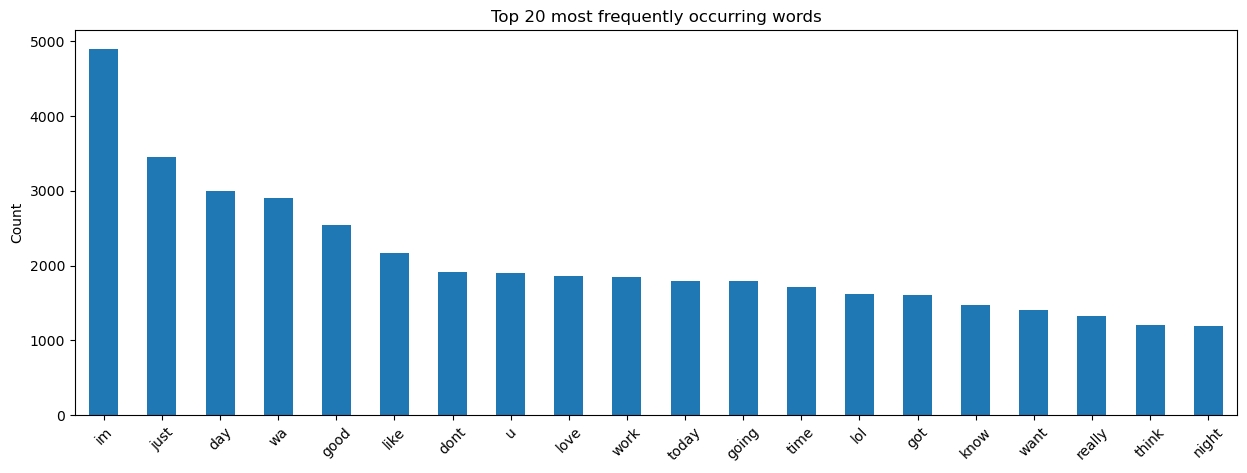

In [50]:
word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

### Modeling

In [51]:
from sklearn.linear_model import LogisticRegression

In [52]:
# Initializing Scale
scaler = MinMaxScaler()

# Fitting scale
scaler.fit(X_train_df_vect)

# Transform scale
X_train_scaled = scaler.transform(X_train_df_vect)
X_validation_scaled = scaler.transform(X_val_df_vect)

In [53]:
# instantiate model
logreg_model = LogisticRegression(max_iter=100000, random_state=1)

# fit the model
logreg_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=100000, random_state=1)

In [54]:
# Training and test score
print(f"Train score: {logreg_model.score(X_train_scaled, y_train)}")
print(f"Validation score: {logreg_model.score(X_validation_scaled, y_val)}")

Train score: 0.7867597235397751
Validation score: 0.7404479578392622


In [73]:
logreg_model.coef_[0]

array([ 0.43498913, -0.35207314, -0.15139518, ...,  0.06812888,
        1.13150564,  0.77978762])

In [74]:
word_coefficients = pd.DataFrame(
    {"coefficients": logreg_model.coef_[0]},
    index=bagofwords_vector.get_feature_names_out()
).sort_values("coefficients", ascending=False)

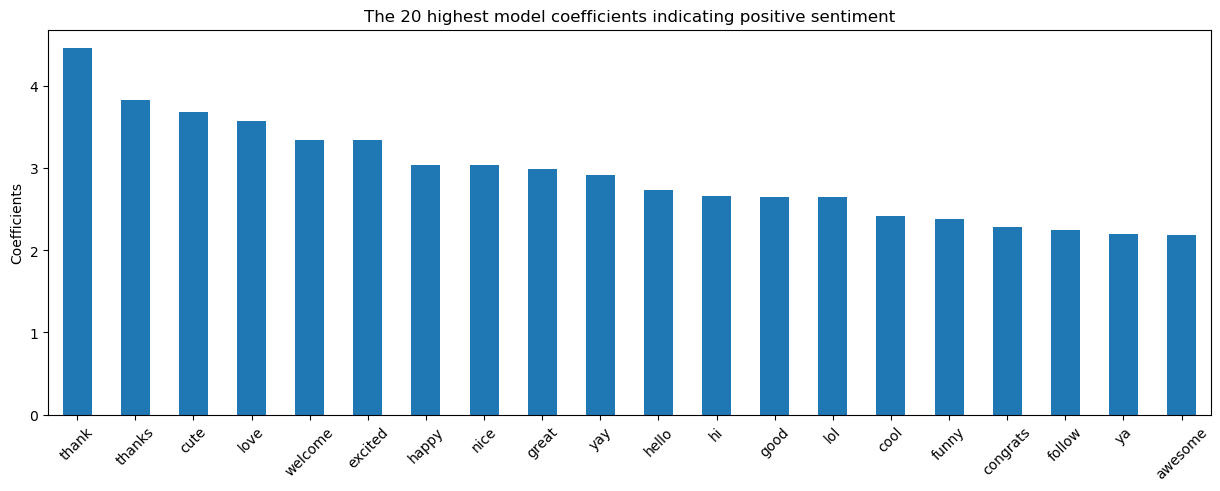

In [75]:
word_coefficients.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 highest model coefficients indicating positive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

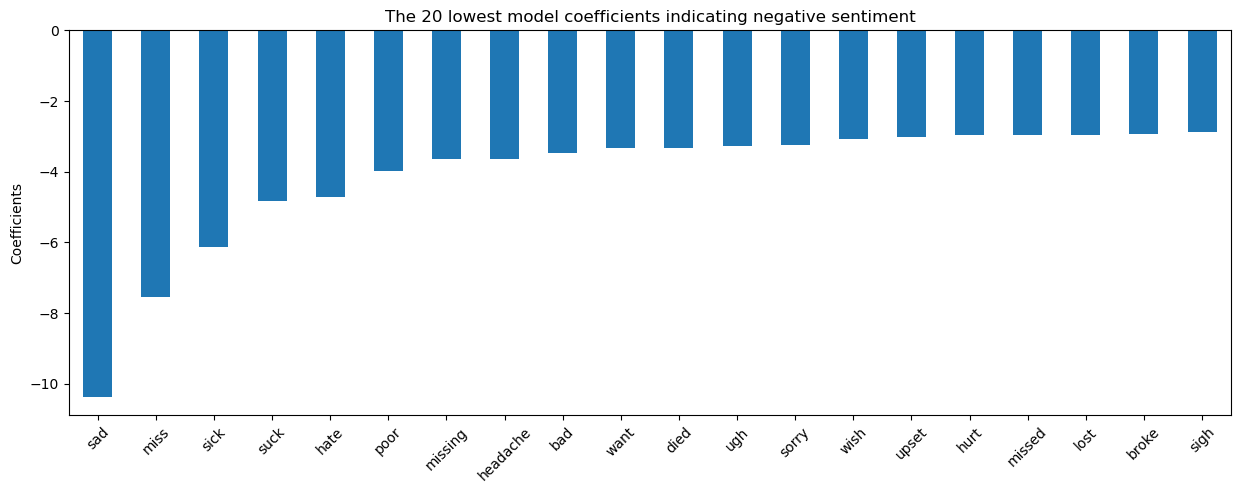

In [76]:
word_coefficients.sort_values("coefficients", ascending=True).head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 lowest model coefficients indicating negative sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

In [80]:
word_coefficients

,coefficients
thank,4.462688
thanks,3.833832
cute,3.683502
love,3.567815
welcome,3.343239
...,...
hate,-4.717654
suck,-4.846733
sick,-6.131555
miss,-7.554811


In [83]:
# instantiate model
logreg = LogisticRegression(solver='lbfgs', max_iter=100000, random_state=1)# saga different regularization and try out

# fit the model
logreg.fit(X_train_scaled, y_train)
# Training and test score
print(f"Train score: {logreg.score(X_train_scaled, y_train)}")
print(f"Validation score: {logreg.score(X_validation_scaled, y_val)}")

Train score: 0.7867597235397751
Validation score: 0.7404479578392622


In [84]:
%%time
# instantiate model
logreg = LogisticRegression(solver='saga', max_iter=100000, random_state=1)# saga different regularization and try out

# fit the model
logreg.fit(X_train_scaled, y_train)
# Training and test score
print(f"Train score: {logreg.score(X_train_scaled, y_train)}")
print(f"Validation score: {logreg.score(X_validation_scaled, y_val)}")

Train score: 0.7867597235397751
Validation score: 0.7404479578392622
CPU times: total: 44.5 s
Wall time: 43.4 s


In [85]:
# instantiate model
logreg = LogisticRegression(solver='liblinear', max_iter=100000, random_state=1)# saga different regularization and try out

# fit the model
logreg.fit(X_train_scaled, y_train)
# Training and test score
print(f"Train score: {logreg.score(X_train_scaled, y_train)}")
print(f"Validation score: {logreg.score(X_validation_scaled, y_val)}")

Train score: 0.786804896779148
Validation score: 0.7404479578392622


In [64]:
# estimators = [('reduce_dim', PCA()),
#             ('logreg_model', LogisticRegression())]
# estimators = [
#     ('reduce_dim', PCA()),
#     ('logreg_model', LogisticRegression())
# ]
# pipe = Pipeline(estimators)

In [100]:
# params = {
#     'reduce_dim__n_components': [1, 10],
#     'logreg_model__solver': ['lbfgs','saga', 'liblinear']
# }

# grid_search_gbc = GridSearchCV(pipe, param_grid=params, cv = 5, n_jobs = -1, verbose = 1)
# grid_search_gbc.fit(X_train_scaled, y_train)
# Wrap grid_search_gbc in tqdm to show progress bar
# grid_search_gbc = tqdm(grid_search_gbc, total=len(grid_search_gbc.cv))

In [95]:
# grid_search_gbc.fit(X_train_transform.todense(), y_train)

In [46]:
# # best score
# print(f"best score: {grid_search.best_score_}")

# # best parameters
# print(f"best parameters: {grid_search.best_params_}")

In [65]:
# setting array
cross_validation_scores = []

c_range = np.array([0.001, 0.01, 0.1, 0.5, 1, 10, 30, 60, 80, 100])

# Do some cross validation
for c in tqdm_notebook(c_range):
    Logreg_model_fold = LogisticRegression(C=c, solver='lbfgs', max_iter=10000, random_state=1)
    cv_score = np.mean(cross_val_score(Logreg_model_fold, X_train_scaled, y_train, cv = 5, n_jobs=-1))
    cross_validation_scores.append(cv_score)
    
    print(f'C: {c}')
    print(f'cv_score {cv_score}')

  0%|          | 0/10 [00:00<?, ?it/s]

C: 0.001
cv_score 0.6961196329132217
C: 0.01
cv_score 0.724669151376805
C: 0.1
cv_score 0.7427158636042854
C: 0.5
cv_score 0.7430320895454806
C: 1.0
cv_score 0.7400958391840431
C: 10.0
cv_score 0.7316710111467579
C: 30.0
cv_score 0.7298415005605075
C: 60.0
cv_score 0.7289154369069121
C: 80.0
cv_score 0.728734748030571
C: 100.0
cv_score 0.7287121568191288


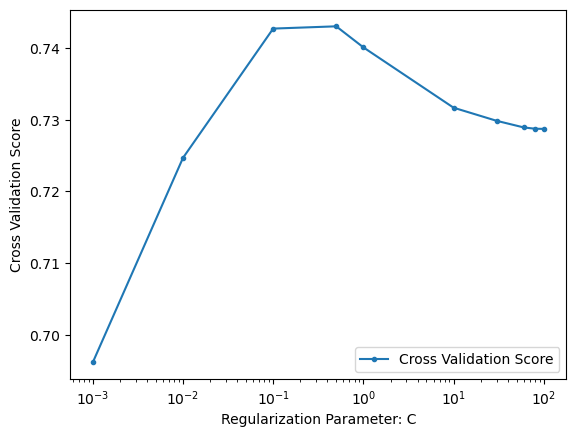

In [66]:
plt.figure()
plt.plot(c_range, cross_validation_scores,label="Cross Validation Score",marker='.')
plt.legend()
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Cross Validation Score')
plt.show()

In [71]:
Logreg_model_fold = LogisticRegression(C=0.5, solver='lbfgs', max_iter=10000, random_state=1)
cv_score = np.mean(cross_val_score(Logreg_model_fold, X_train_transform, y_train, cv = 5, n_jobs=-1))
cv_score

0.7430320895454806